In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

Импортируем данные которые на сделал парсер

In [2]:
df = pd.read_excel('concat_data.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12510 entries, 0 to 12509
Data columns (total 3 columns):
 #   Column                                                                                         Non-Null Count  Dtype 
---  ------                                                                                         --------------  ----- 
 0   Ежемесячный отчет по совокупному фактическому потреблению электрической энергии в субъекте РФ  12456 non-null  object
 1   Unnamed: 1                                                                                     12460 non-null  object
 2   Unnamed: 2                                                                                     12410 non-null  object
dtypes: object(3)
memory usage: 293.3+ KB


In [4]:
df.head()

,Ежемесячный отчет по совокупному фактическому потреблению электрической энергии в субъекте РФ,Unnamed: 1,Unnamed: 2
0,Субъект РФ:,Свердловская область,NaN
1,Отчетный период:,c 01.10.2021 по 31.10.2021,NaN
2,NaN,NaN,NaN
3,Дата,Час,NaN
4,NaN,NaN,Совокупное фактическое потребление электрическ...


После парсинга данные надо обработать и убрать лишни строки, присвоить нормальные имена столбцам

In [5]:
# Переименовываем столбцы
df = df.rename(columns={'Ежемесячный отчет по совокупному фактическому потреблению электрической энергии в субъекте РФ': 'date', 'Unnamed: 1': 'hour', 'Unnamed: 2': 'consumption'})

удалим строки с Nan это позволит нам избавиться от тех строк после парсинга данных где были указаны названия столбцов от каждой таблицы

In [6]:
df = df.dropna()

Удаляем из первого столбца строку с значением 1, так это строка применялась для обозначения порядкового нмоера столбца из данных после парсинга

In [7]:
df = df[df['date'] != 1]

In [8]:
# Преобразуем столбец 'date' в тип datetime
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [9]:
# Сбрасываем индексацию и восстанавливаем порядок индексов
df = df.reset_index(drop=True)

In [10]:
df['date'] = pd.to_datetime(df['date'])
df['hour'] = pd.to_timedelta(df['hour'], unit='h')
df['new_date'] = df['date'] + df['hour']

In [11]:
# Удаляем столбец 'date'
df = df.drop('date', axis=1)

In [12]:
# Удаляем столбец 'hour'
df = df.drop('hour', axis=1)

In [13]:
df.head()

,consumption,new_date
0,3860.564,2021-10-01 01:00:00
1,3856.057,2021-10-01 02:00:00
2,3870.914,2021-10-01 03:00:00
3,3951.075,2021-10-01 04:00:00
4,4078.359,2021-10-01 05:00:00


## EDA
Данные представляют собой наблюдения за каждый час, каждый час фиксируется объем суммарного фактического потребления электрической энергии в субъекте РФ

Проверим количество отсутствующих строк данных, по возможности востановим их

In [17]:
# Преобразуум столбец 'new_date' в формат даты
df['new_date'] = pd.to_datetime(df['new_date'])

# Создадим DataFrame с последовательными датами
min_date = df['new_date'].min()
max_date = df['new_date'].max()
sequence_dates = pd.date_range(start=min_date, end=max_date, freq='H')
sequence_df = pd.DataFrame({'sequence_date': sequence_dates})

# Объединим исходный DataFrame с последовательными датами
merged_df = pd.merge(sequence_df, df, left_on='sequence_date', right_on='new_date', how='left')


print("Исходные данные с последовательными датами:")
print(merged_df[['consumption', 'sequence_date']].count())

# Находим пропущенные даты
missing_dates = merged_df[merged_df['consumption'].isna()]['sequence_date'].count()

print("\nПропущенные даты:")
print(missing_dates)

Исходные данные с последовательными датами:
consumption      12360
sequence_date    18264
dtype: int64

Пропущенные даты:
5904


5904 строки пропущенных значений

В датасете merged_df Получаем все строки до часа, вместо отсутствующих значений consumption подставляем NaN, создаем дополнительный столбик с указанием date полного с каждым часом, и опираясь на это будет востанавливать данные

Все пусты значения я решил востановить двигаясь на 24 строки назад, тоесть на сутки, с помощью этого мы сможем заполнить данные особо не вредя

In [18]:
count = 0

# Запустим цикл, пока есть NaN значения в столбце "consumption"
while merged_df['consumption'].isna().any():
    merged_df['consumption'] = merged_df['consumption'].fillna(merged_df['consumption'].shift(24))
    count += 1

print("Количество итераций:", count)

Количество итераций: 10


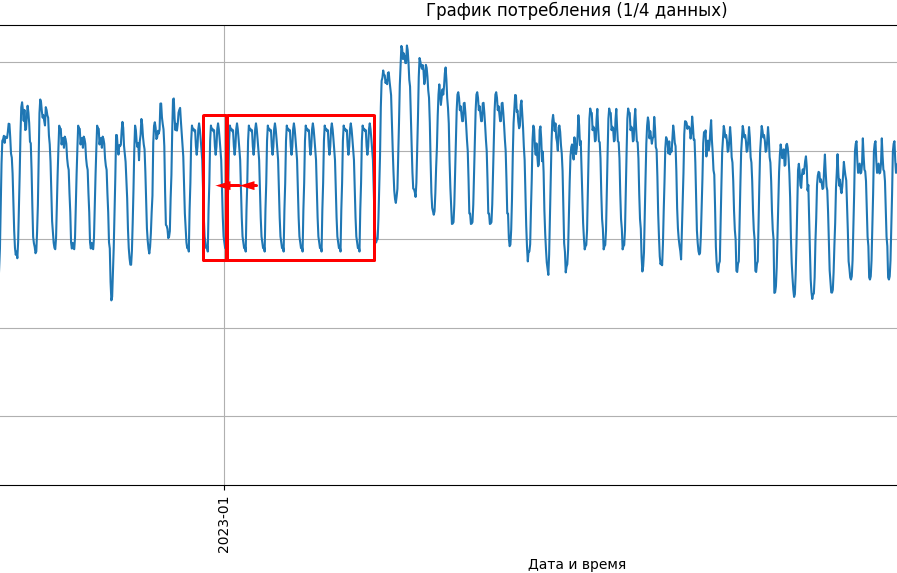

Сделаем визуализацию потребления за 2 года

In [19]:
# Установим столбец 'date_time' как индекс
merged_df.set_index('sequence_date', inplace=True)

In [20]:
import matplotlib.dates as mdates

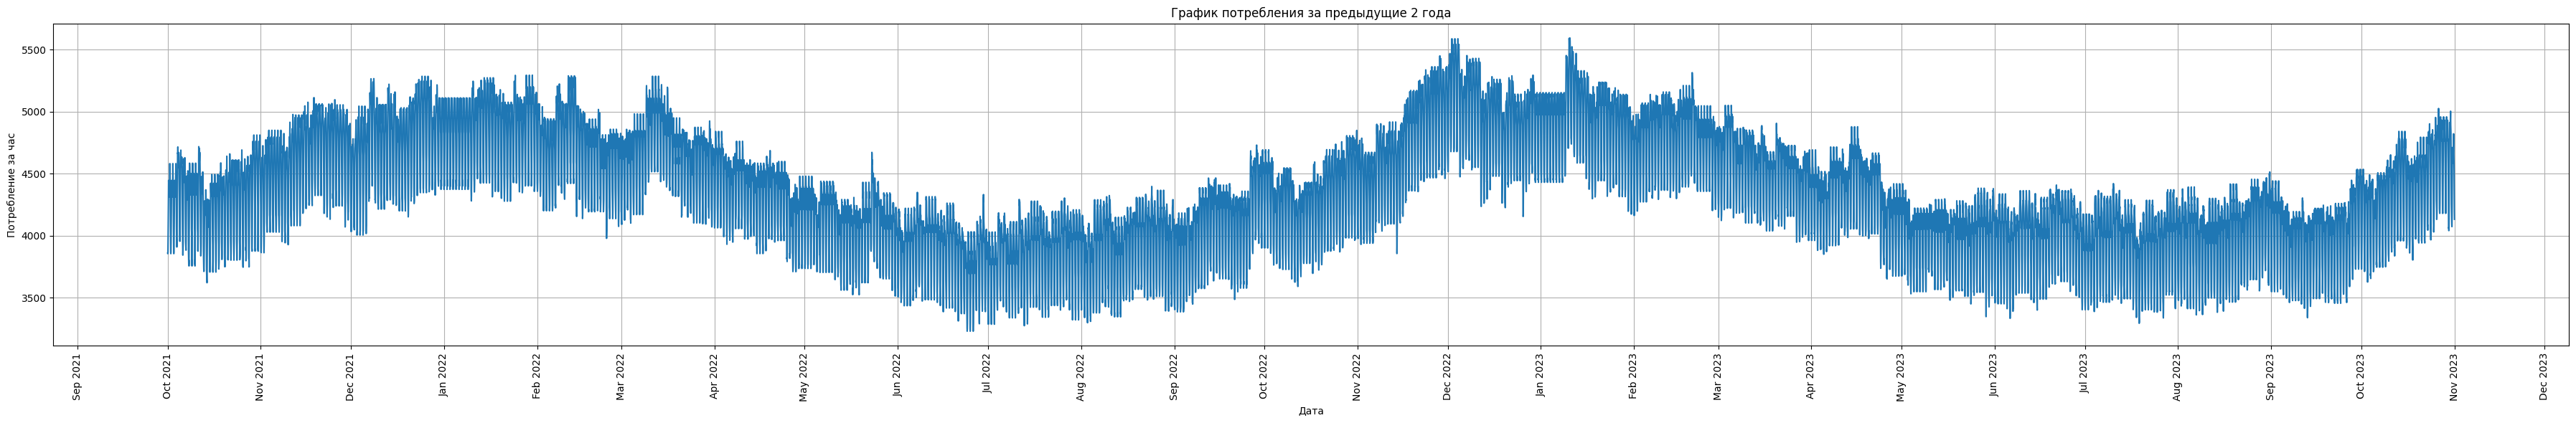

In [22]:
# Построим график
plt.figure(figsize=(36, 6))
plt.plot(merged_df.index, merged_df['consumption'], linestyle='-')
plt.title('График потребления за предыдущие 2 года')
plt.xlabel('Дата')
plt.ylabel('Потребление за час')
plt.grid(True)

# Создаем форматер даты для месяцев
date_format = mdates.DateFormatter('%b %Y')

# Установим деления на оси X с помощью форматера даты для месяцев
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(date_format)

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

## Наблюдения
- Сезонность - заметна сезонная вариация потребления электроэнергии, с пиками потребления зимой и снижением летом
- Дневная динамика - Потребление электроэнергии, выше в дневные часы, особенно в рабочие дни, что связано с промышленной и коммерческой активностью
- Рост общего потребления - увеличение потребления электроэнергии с течением времени, это может свидетельствовать о росте населения или экономическом развитии региона


## Более подробный график, здесь мы можем более детально рассмотреть потребления за прошлый месяц, и проанализировать тренды и аномалии

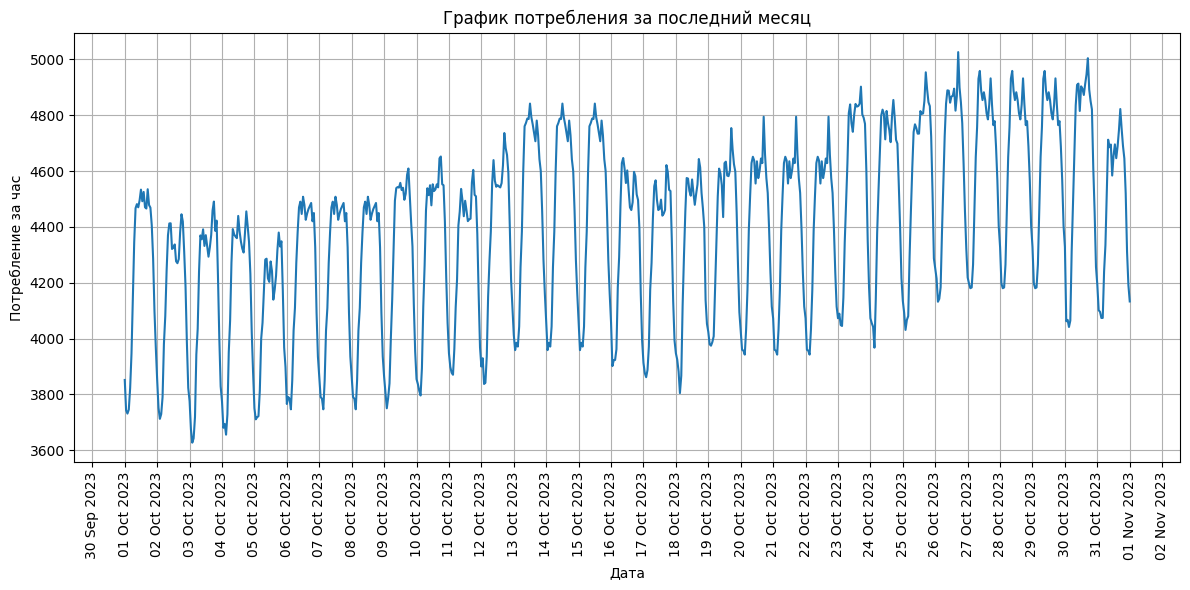

In [23]:
# Дата начала последнего месяца в данных
last_month_start = pd.Timestamp.now() - pd.DateOffset(months=1)
last_month_start = last_month_start.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

# срез данных только за последний месяц
last_month_df = merged_df[last_month_start:]

# график для последнего месяца данных
plt.figure(figsize=(12, 6))
plt.plot(last_month_df.index, last_month_df['consumption'], linestyle='-')
plt.title('График потребления за последний месяц')
plt.xlabel('Дата')
plt.ylabel('Потребление за час')
plt.grid(True)

# форматер даты для дней месяца и года
date_format = mdates.DateFormatter('%d %b %Y')

# деления на оси X с помощью форматера даты
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(date_format)

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

## Далее обрабатываем пустые значения, заменяя их на наблюдения 24 часа назад, так мы заполним пропуски

In [24]:
# Возвращаем индекс 'new_date'
merged_df.reset_index(inplace=True)

In [25]:
merged_df

,sequence_date,consumption,new_date
0,2021-10-01 01:00:00,3860.564,2021-10-01 01:00:00
1,2021-10-01 02:00:00,3856.057,2021-10-01 02:00:00
2,2021-10-01 03:00:00,3870.914,2021-10-01 03:00:00
3,2021-10-01 04:00:00,3951.075,2021-10-01 04:00:00
4,2021-10-01 05:00:00,4078.359,2021-10-01 05:00:00
...,...,...,...
18259,2023-10-31 20:00:00,4645.252,2023-10-31 20:00:00
18260,2023-10-31 21:00:00,4520.692,2023-10-31 21:00:00
18261,2023-10-31 22:00:00,4311.215,2023-10-31 22:00:00
18262,2023-10-31 23:00:00,4191.804,2023-10-31 23:00:00


In [26]:
# Удаляем столбец 'new_date'
merged_df = merged_df.drop('new_date', axis=1)

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18264 entries, 0 to 18263
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sequence_date  18264 non-null  datetime64[ns]
 1   consumption    18264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 285.5 KB


Преобразуем sequence_date в datetime и установим индекс

In [28]:
merged_df['sequence_date'] = pd.to_datetime(merged_df['sequence_date'])
merged_df.set_index('sequence_date', inplace=True)

In [29]:
merged_df

,consumption
sequence_date,
2021-10-01 01:00:00,3860.564
2021-10-01 02:00:00,3856.057
2021-10-01 03:00:00,3870.914
2021-10-01 04:00:00,3951.075
2021-10-01 05:00:00,4078.359
...,...
2023-10-31 20:00:00,4645.252
2023-10-31 21:00:00,4520.692
2023-10-31 22:00:00,4311.215


In [30]:
# индекс 'new_date'
merged_df.reset_index(inplace=True)

In [31]:
print(merged_df)

            sequence_date  consumption
0     2021-10-01 01:00:00     3860.564
1     2021-10-01 02:00:00     3856.057
2     2021-10-01 03:00:00     3870.914
3     2021-10-01 04:00:00     3951.075
4     2021-10-01 05:00:00     4078.359
...                   ...          ...
18259 2023-10-31 20:00:00     4645.252
18260 2023-10-31 21:00:00     4520.692
18261 2023-10-31 22:00:00     4311.215
18262 2023-10-31 23:00:00     4191.804
18263 2023-11-01 00:00:00     4133.159

[18264 rows x 2 columns]


После обработки пустых проверим еще раз

In [32]:
df_filled = merged_df

In [33]:
# DataFrame с последовательными датами
min_date = df_filled['sequence_date'].min()
max_date = df_filled['sequence_date'].max()
sequence_dates = pd.date_range(start=min_date, end=max_date, freq='H')
sequence_df = pd.DataFrame({'sequence_date': sequence_dates})

# Объединяем исходный DataFrame с последовательными датами
merged_df = pd.merge(sequence_df, df_filled, left_on='sequence_date', right_on='sequence_date', how='left')

print("Исходные данные с последовательными датами:")
print(merged_df[['consumption', 'sequence_date']])

missing_dates = merged_df[merged_df['consumption'].isna()]['sequence_date']

print("\nПропущенные даты:")
print(missing_dates)

Исходные данные с последовательными датами:
       consumption       sequence_date
0         3860.564 2021-10-01 01:00:00
1         3856.057 2021-10-01 02:00:00
2         3870.914 2021-10-01 03:00:00
3         3951.075 2021-10-01 04:00:00
4         4078.359 2021-10-01 05:00:00
...            ...                 ...
18259     4645.252 2023-10-31 20:00:00
18260     4520.692 2023-10-31 21:00:00
18261     4311.215 2023-10-31 22:00:00
18262     4191.804 2023-10-31 23:00:00
18263     4133.159 2023-11-01 00:00:00

[18264 rows x 2 columns]

Пропущенные даты:
Series([], Name: sequence_date, dtype: datetime64[ns])


Теперь пропущенных значений нет

In [34]:
# Проверка стационарности
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_filled['consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.908100
p-value: 0.328260


- data - будем диффиренцировать
- df_filled - оставим как есть

In [35]:
data = df_filled

## Выполнение дифференцирования

In [36]:
# Выполняем дифференцирование (первую разность)
data['consumption_diff'] = data['consumption'].diff()

In [37]:
data

,sequence_date,consumption,consumption_diff
0,2021-10-01 01:00:00,3860.564,NaN
1,2021-10-01 02:00:00,3856.057,-4.507
2,2021-10-01 03:00:00,3870.914,14.857
3,2021-10-01 04:00:00,3951.075,80.161
4,2021-10-01 05:00:00,4078.359,127.284
...,...,...,...
18259,2023-10-31 20:00:00,4645.252,-44.645
18260,2023-10-31 21:00:00,4520.692,-124.560
18261,2023-10-31 22:00:00,4311.215,-209.477
18262,2023-10-31 23:00:00,4191.804,-119.411


## Заполним NaN значение 0

In [38]:
# Заполнить NaN-значения нулями
data['consumption_diff'].fillna(0, inplace=True)

In [ ]:
#data['consumption'] = data['consumption'].fillna(data['consumption'].mean())
# Тут заполнял средними но мне это не подходит, заменил на 0

In [39]:
# Проверка данных на наличие nan или inf
print("Есть ли NaN в данных:", data['consumption_diff'].isna().any())
print("Есть ли inf в данных:", np.isinf(data['consumption_diff']).any())

Есть ли NaN в данных: False
Есть ли inf в данных: False


In [40]:
data.set_index('sequence_date', inplace=True)

## Построим график дифференцированных данных

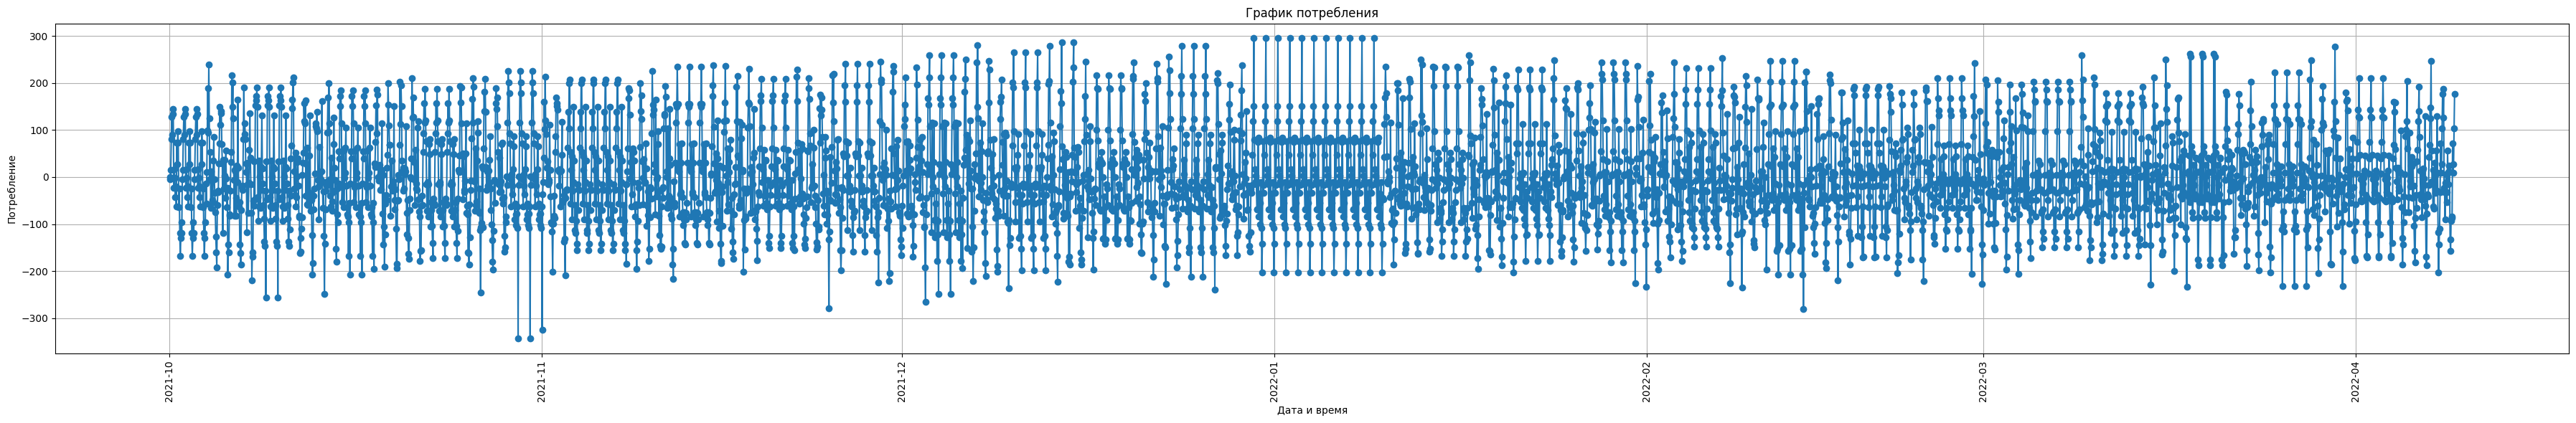

In [41]:
quarter_data = data.iloc[:int(len(data) * 0.25)]
# Построим график
plt.figure(figsize=(36, 6))
plt.plot(quarter_data.index, quarter_data['consumption_diff'], marker='o', linestyle='-')
plt.title('График потребления')
plt.xlabel('Дата и время')
plt.ylabel('Потребление')
plt.grid(True)
# Подпишем индексы снизу вертикально
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

Теперь проверим на стационарность

In [42]:
# Проверка стационарности
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['consumption_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -29.905460
p-value: 0.000000


результаты теста Дики-Фуллера (ADF) после дифференцирования данных показывают значительные изменения:

ADF Statistic: -29.90: Это значение значительно ниже пороговых значений, обычно используемых для определения стационарности (например, -3.5, -2.9, -2.6 в зависимости от размера выборки и уровня уверенности). Чем меньше значение (то есть чем более отрицательное), тем меньше вероятность наличия единичного корня в ряде, что указывает на стационарность.

p-value: 0.00: Это значение близко к нулю, что гораздо меньше порога 0.05, обычно используемого для определения статистической значимости. Это означает, что нулевая гипотеза о наличии единичного корня (нестационарности) ряда может быть уверенно отвергнута

## С помощью auto_arima подберем параметры для модели ARIMA, будеи использоать только часть данных для подбора

In [43]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


Сократим датасет для автоподбора параметров обучения

In [44]:
middle_index = len(data) // 48
# Создаем новый датасет, содержащий только первую половину данных
reduced_data = data.iloc[:middle_index]

In [45]:
# Подбор параметров ARIMA
import pmdarima as pm
model = pm.auto_arima(reduced_data['consumption'], seasonal=True, m=24,
                      d=1, D=1, max_p=5, max_q=5, trace=True,
                      error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=31.07 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=3658.571, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=3627.590, Time=1.26 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=3601.195, Time=6.34 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=3658.667, Time=0.51 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=8.81 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=50.63 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=3627.546, Time=2.10 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=29.02 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=3602.550, Time=4.68 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=3600.786, Time=7.42 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=inf, Time=4.27 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=36.00 sec
 ARIMA(1,1,1)(0,1,2)[24]             : AIC=inf, Time=59.52 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=inf, T

## Лучшая модель для наших данных ARIMA(1,1,1)(0,1,1)[24]  

In [46]:
data2 = data

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18264 entries, 2021-10-01 01:00:00 to 2023-11-01 00:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   consumption       18264 non-null  float64
 1   consumption_diff  18264 non-null  float64
dtypes: float64(2)
memory usage: 428.1 KB


## Для оценки модели, отделим часть данных, это будет крайний месяц

In [48]:
# Отделение последних 24 часов для тестирования
train = data.iloc[:-24]
test = data.iloc[-24:]

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18264 entries, 2021-10-01 01:00:00 to 2023-11-01 00:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   consumption       18264 non-null  float64
 1   consumption_diff  18264 non-null  float64
dtypes: float64(2)
memory usage: 428.1 KB


## Обучение модели ARIMA

In [50]:
# Обучение модели ARIMA
model_fit = model.fit(train['consumption_diff'])

In [51]:
# Прогнозирование
forecast = model_fit.predict(n_periods=24)  # Прогноз на 24 часа вперёд

In [52]:
# Прогнозирование на первые 24 часа
forecast_2 = model_fit.predict(n_periods=len(forecast)+24)

In [53]:
forecast_2 = forecast_2[-24:]

## Построим график актуальных, тестовых и предсказанных данных по потреблению

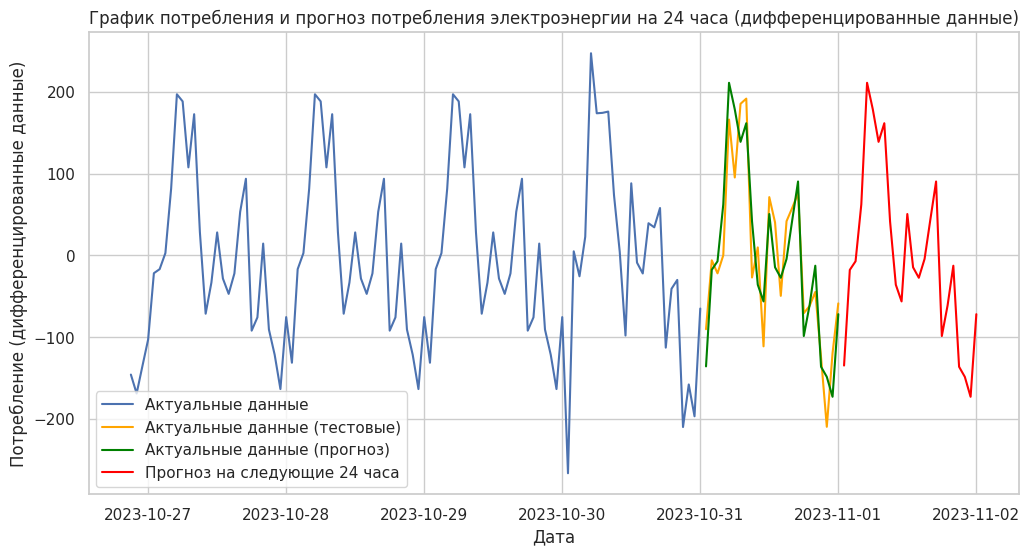

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train['consumption_diff'][-100:], label='Актуальные данные')
plt.plot(test.index, test['consumption_diff'], label='Актуальные данные (тестовые)', color='orange')
plt.plot(test.index, forecast, label='Актуальные данные (прогноз)', color='green')
plt.plot(test.index + pd.to_timedelta(24, unit='h'), forecast_2, label='Прогноз на следующие 24 часа', color='red')
plt.title('График потребления и прогноз потребления электроэнергии на 24 часа (дифференцированные данные)')
plt.xlabel('Дата')
plt.ylabel('Потребление (дифференцированные данные)')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Оценка модели
mse = mean_squared_error(test['consumption_diff'], forecast)
print(f"Средняя квадратичная ошибка (MSE): {mse}")
rmse = sqrt(mse)
print(f"RMSE: {rmse}")
r2 = r2_score(test['consumption_diff'], forecast)
print(f"Коэффициент детерминации (R^2): {r2}")
mae = mean_absolute_error(test['consumption_diff'], forecast)
print(f"Средняя абсолютная ошибка (MAE): {mae}")



Средняя квадратичная ошибка (MSE): 1802.244690528815
RMSE: 42.45285256056199
Коэффициент детерминации (R^2): 0.817780150372702
Средняя абсолютная ошибка (MAE): 36.68842006869249


## Востановим данные после дифференцирования с помощью куммулятивной суммы и начального значения

In [68]:
# Восстановление исходных значений на основе дифференцированных предсказаний
last_known_value = data['consumption'].iloc[-24 - 1]  # Последнее известное значение перед прогнозом
cumulative_forecast = last_known_value + forecast.cumsum()
cumulative_forecast_2 = last_known_value + forecast_2.cumsum()

## Построим график потребления электрической энергии и прогнозированных данных

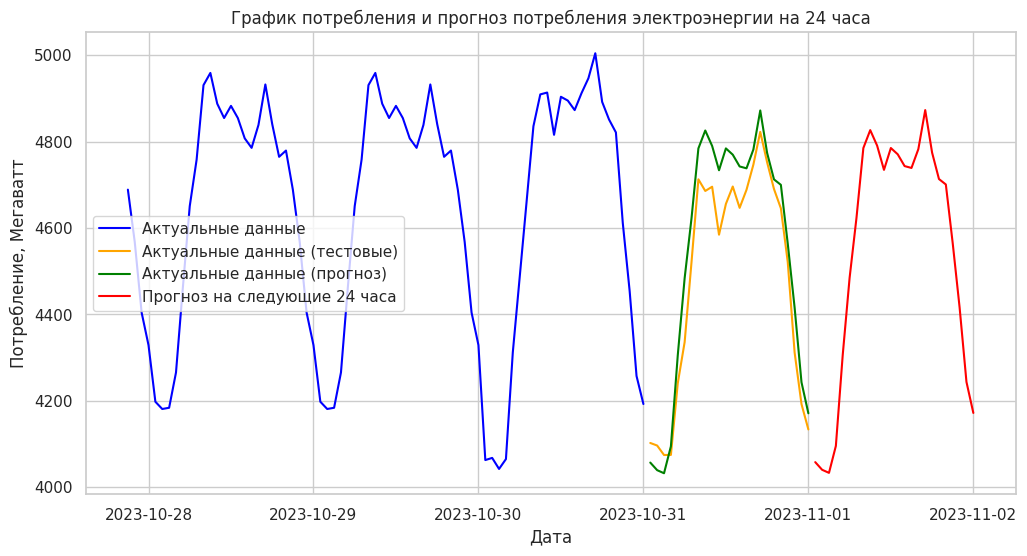

In [70]:
# Подготовка графика
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:-24], data['consumption'][-100:-24], label='Актуальные данные', color='blue')
plt.plot(test.index, data['consumption'][-24:], label='Актуальные данные (тестовые)', color='orange')
plt.plot(test.index, cumulative_forecast, label='Актуальные данные (прогноз)', color='green')
plt.plot(test.index + pd.to_timedelta(24, unit='h'), cumulative_forecast_2, label='Прогноз на следующие 24 часа', color='red')
plt.title('График потребления и прогноз потребления электроэнергии на 24 часа')
plt.xlabel('Дата')
plt.ylabel('Потребление, Мегаватт')
plt.legend()
plt.grid(True)
plt.show()

## Выведем предсказанные данные в сессионое хранилище

файлы будут иметь имена
- data_actual.csv
- data_actual_test.csv
- cumulative_forecast.csv
- cumulative_forecast_2.csv

In [71]:
data['consumption'][-100:-24].to_csv("data_actual.csv", index=True)

In [72]:
data['consumption'][-24:].to_csv("data_actual_test.csv", index=True)

In [73]:
# Преобразование Series в DataFrame
cumulative_forecast_df = cumulative_forecast.to_frame()
cumulative_forecast_df.columns = ['consumption']
cumulative_forecast_df.index.name = 'sequence_date'
cumulative_forecast_df.to_csv("cumulative_forecast.csv", index=True)

In [74]:
# Преобразование Series в DataFrame
cumulative_forecast_2_df = cumulative_forecast_2.to_frame()
# Присвоение названий столбцам
cumulative_forecast_2_df.index.name = 'sequence_date'
cumulative_forecast_2_df.columns = ['consumption']
cumulative_forecast_2_df.to_csv("cumulative_forecast_2.csv", index=True)

# Модель LSTM

In [ ]:
data2.reset_index(inplace=True)

In [ ]:
data2.set_index('sequence_date', inplace=True)

## Подготовка данных для модели LSTM

In [ ]:
# Группировка по месяцам и суммирование значений потребления
monthly_consumption = data2['consumption'].resample('M').sum().to_frame(name='consumption')

In [ ]:
monthly_consumption = monthly_consumption.iloc[:-1]

In [ ]:
monthly_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2021-10-31 to 2023-10-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


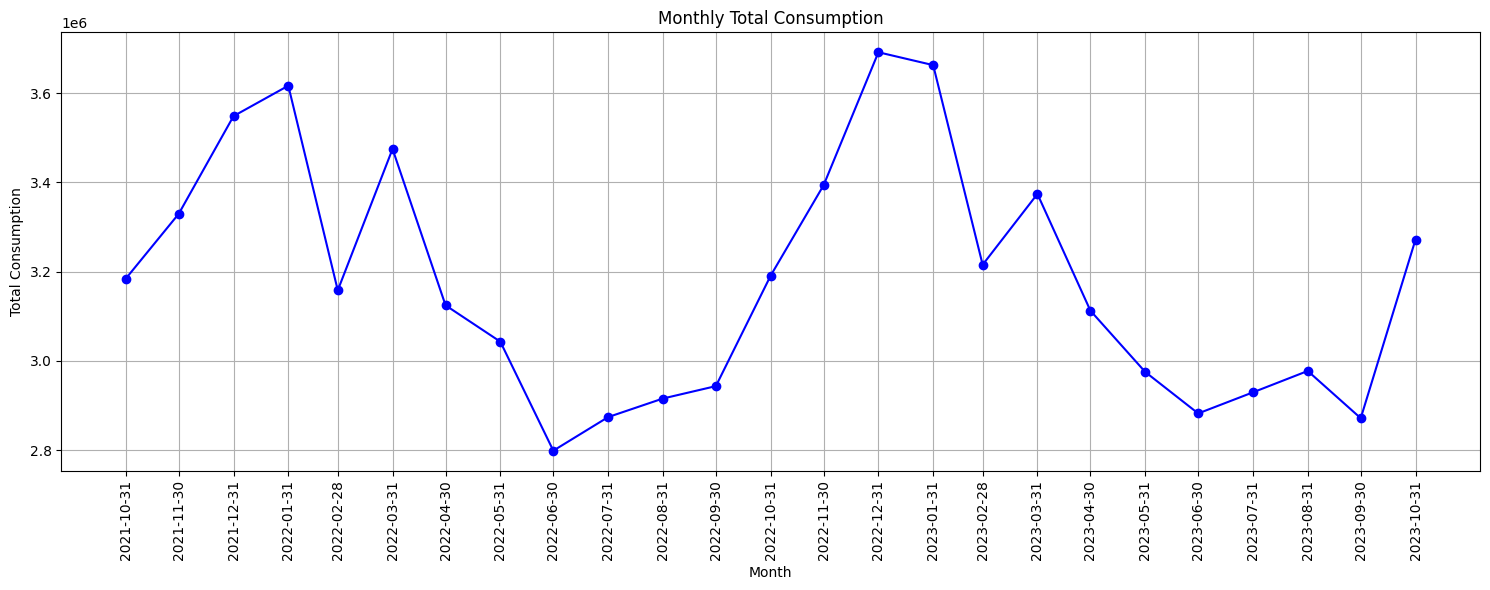

In [ ]:
# Построение графика
plt.figure(figsize=(15, 6))
plt.plot(monthly_consumption.index, monthly_consumption['consumption'], marker='o', color='blue')
plt.title('Граффие суммарного месячного потребления электроэнергии')
plt.xlabel('Месяц')
plt.ylabel('Общее потребление')
plt.grid(True)
plt.xticks(monthly_consumption.index, rotation=90)  # Поворачиваем метки на 90 градусов
plt.tight_layout()  # Автоматическое корректирование расположения элементов
plt.show()

In [ ]:
#del model

In [ ]:
#del model_fit

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator

Новая модель

In [ ]:
# Отделение последнего месяца для тестирования
train_df = monthly_consumption[:-1]
test_df = monthly_consumption[-1:]

Старые данные

In [ ]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_df)

# Создание последовательностей для обучения модели LSTM
n_input = 3  # Количество временных шагов (например, 3 месяца)К
n_features = 1  # Количество признаков (в данном случае 1 - потребление)
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(generator, epochs=100)

Epoch 1/200
21/21 [==============================] - 4s 10ms/step - loss: 0.2109
Epoch 2/200
21/21 [==============================] - 0s 9ms/step - loss: 0.1449
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 0.1061
Epoch 4/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0776
Epoch 5/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0729
Epoch 6/200
21/21 [==============================] - 0s 10ms/step - loss: 0.0747
Epoch 7/200
21/21 [==============================] - 0s 11ms/step - loss: 0.0753
Epoch 8/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0707
Epoch 9/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0704
Epoch 10/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0705
Epoch 11/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0694
Epoch 12/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0700
Epoch 13/200
21/21 [=============

## Отобразим график обучения модели LSTM

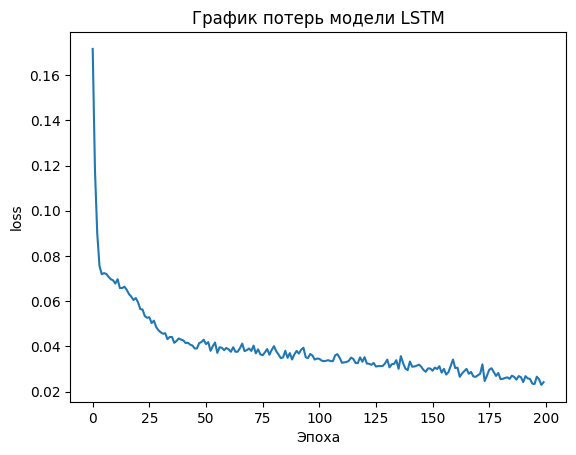

In [ ]:
plt.plot(history.history['loss'])
plt.title('График потерь модели LSTM')
plt.ylabel('loss')
plt.xlabel('Эпоха')
plt.show()

In [ ]:
# Подготовка тестовых данных и прогнозирование
test_data = scaled_data[-(n_input + 1):]  # Последние данные для теста
test_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=1)
predictions = model.predict(test_generator)

# Обратное преобразование прогноза
predicted_consumption = scaler.inverse_transform(predictions)

# Оценка модели
true_consumption = test_df['consumption'].values[-len(test_df):]

1/1 [==============================] - 0s 54ms/step


## Расчитаем метрики качества прогнозирования

In [ ]:
# Расчет MSE
mse = np.mean((np.array(true_consumption) - np.array(predicted_consumption)) ** 2)

# Расчет RMSE
rmse = np.sqrt(mse)

# Расчет MAE
mae = np.mean(np.abs(np.array(true_consumption) - np.array(predicted_consumption)))

print(f'mse = {mse}')
print(f'rmse = {rmse}')
print(f'mae = {mae}')

mse = 22582657074.123497
rmse = 150275.27100000018
mae = 150275.27100000018


In [ ]:
# Создайте DataFrame с индексами следующего месяца
next_month_index = train_df.index[-1] + pd.DateOffset(months=1)
predicted_consumption_df = pd.DataFrame(index=[next_month_index])

# Добавьте столбец с предсказанными значениями в новый DataFrame
predicted_consumption_df['consumption'] = predicted_consumption.flatten()

# Выведите результат
print(predicted_consumption_df)

            consumption
2023-10-30   3121557.75


In [ ]:
print(train_df.index)
print(test_df.index)
print(predicted_consumption_df.index)


DatetimeIndex(['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30'],
              dtype='datetime64[ns]', name='sequence_date', freq='M')
DatetimeIndex(['2023-10-31'], dtype='datetime64[ns]', name='sequence_date', freq='M')
DatetimeIndex(['2023-10-30'], dtype='datetime64[ns]', freq=None)


## Построим график актуальных данных, тестовых и данных прогноза

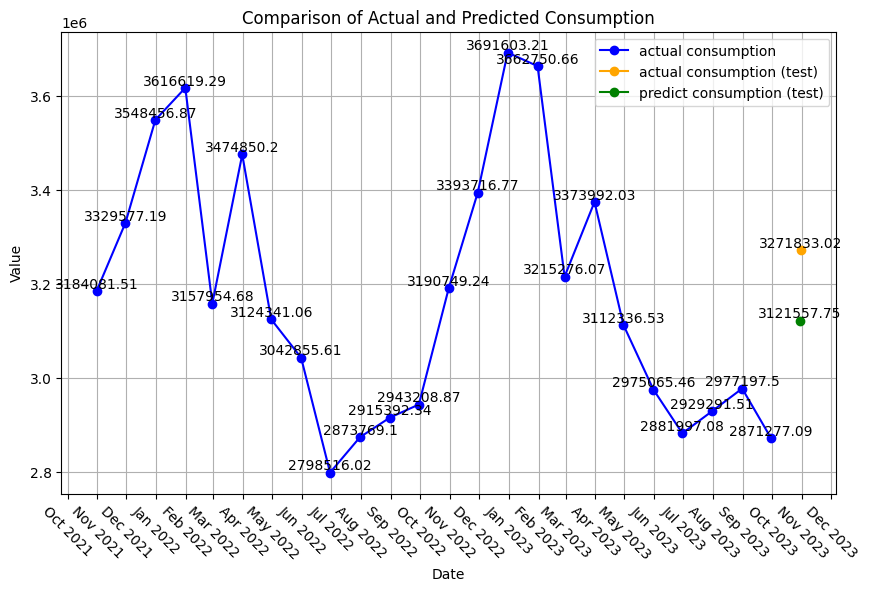

In [ ]:
# Создание графика
plt.figure(figsize=(10, 6))

# График для актуального потребления
plt.plot(train_df.index, train_df['consumption'], label='Актуальные данные', color='blue', marker='o')
plt.plot(test_df.index, test_df['consumption'], label='Актуальные данные (тестовые)', color='orange', marker='o')
plt.plot(predicted_consumption_df.index, predicted_consumption_df['consumption'], label='Прогноз', color='green', marker='o')

# Настройка меток времени
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Добавление сетки
plt.grid(True)

# Настройка графика
plt.title('График потреблени и прогноз потребления электроэнергии')
plt.xlabel('Дата')
plt.ylabel('Месячное потребление')
plt.xticks(rotation=-45)

# Добавление легенды
plt.legend()

# Добавление значений к каждой точке
for i, value in enumerate(train_df['consumption']):
    plt.text(train_df.index[i], value, str(round(value, 2)), ha='center', va='bottom')
for i, value in enumerate(test_df['consumption']):
    plt.text(test_df.index[i], value, str(round(value, 2)), ha='center', va='bottom')
for i, value in enumerate(predicted_consumption_df['consumption']):
    plt.text(predicted_consumption_df.index[i], value, str(round(value, 2)), ha='center', va='bottom')

# Отображение графика
plt.show()

# Сравнение моделей

In [58]:
import seaborn as sns

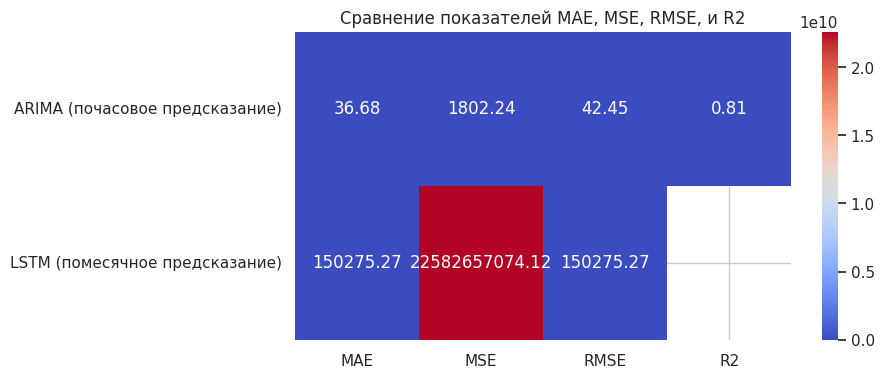

In [61]:
metrics = {
    'MAE': [36.68, 150275.27],
    'MSE': [1802.24, 22582657074.12],
    'RMSE': [42.45, 150275.27],
    'R2': [0.81, None]
}

# Создаем DataFrame из словаря
metrics_df = pd.DataFrame(metrics, index=['ARIMA (почасовое предсказание)', 'LSTM (помесячное предсказание)'])

# Устанавливаем стиль seaborn
sns.set(style="whitegrid")

# Создаем графическое представление таблицы с помощью heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(metrics_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Сравнение показателей MAE, MSE, RMSE, и R2")
plt.show()

### Вывод
На основе анализа данных о потреблении электроэнергии и результатов моделей прогнозирования, мы определили, что модель ARIMA (AutoRegressive Integrated Moving Average) демонстрирует наилучшую производительность в сравнении с моделью LSTM (Long Short-Term Memory) для наших данных.

Модель ARIMA показала более низкие значения средней абсолютной ошибки (MAE), средней квадратичной ошибки (MSE) и корня из средней квадратичной ошибки (RMSE). Кроме того, коэффициент детерминации (R2) для модели ARIMA составляет 0.81, что указывает на хорошее качество прогнозов.

На основе этих результатов, мы приняли решение выбрать модель ARIMA для прогнозирования и использования в нашем проекте